
# Convolutional Wasserstein Distances: 

Efficient Optimal Transportation on Geometric Domains.

In [1]:
import numpy as np
import pylab as pl
# import ot
from scipy import optimize
from PIL import Image
%matplotlib inline

# Loading Data

There are three datasets. Each one consists of four images. You can run anyone before running other parts.

In [2]:
# Retinal OCT images: https://www.kaggle.com/paultimothymooney/kermany2018#DRUSEN-1083159-1.jpeg
for image in ['data/NORMAL.jpeg', 'data/CNV.jpeg', 'data/DRUSEN.jpeg', 'data/DME.jpeg']:
    img = Image.open(image)
    rgb_im = img.convert('RGB').resize((128,128))
    rgb_im.save(image.split('.')[0]+'1.jpeg', "JPEG", optimize=True)
    img.close()


# f1 = 1 - pl.imread('data/NORMAL1.jpeg')[:, :, 2]
# f2 = 1 - pl.imread('data/CNV1.jpeg')[:, :, 2]
# f3 = 1 - pl.imread('data/DRUSEN1.jpeg')[:, :, 2]
# f4 = 1 - pl.imread('data/DME1.jpeg')[:, :, 2]

f1 =  pl.imread('data/NORMAL1.jpeg')[:, :, 2]
f2 =  pl.imread('data/CNV1.jpeg')[:, :, 2]
f3 =  pl.imread('data/DRUSEN1.jpeg')[:, :, 2]
f4 =  pl.imread('data/DME1.jpeg')[:, :, 2]

# scale
f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)
A = np.array([f1, f2, f3, f4])

nb_images = 4

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

In [6]:
# ocean
for image in ['data/ocean_day.jpg', 'data/ocean_sunset.jpg', 'data/autumn.jpg', 'data/woods.jpg']:
    img = Image.open(image)
    rgb_im = img.convert('RGB').resize((64*3,64*3))
    rgb_im.save(image.split('.')[0]+'1.jpg', "JPEG", optimize=True)
    img.close()


f1 = 1 - pl.imread('data/ocean_day1.jpg')[:, :, 2]
f2 = 1 - pl.imread('data/ocean_sunset1.jpg')[:, :, 2]
f3 = 1 - pl.imread('data/autumn1.jpg')[:, :, 2]
f4 = 1 - pl.imread('data/woods1.jpg')[:, :, 2]

# scale
f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)
A = np.array([f1, f2, f3, f4])

nb_images = 4

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

In [4]:
# Original
f1 = 1 - pl.imread('data/redcross.png')[:, :, 2]
f2 = 1 - pl.imread('data/duck.png')[:, :, 2]
f3 = 1 - pl.imread('data/heart.png')[:, :, 2]
f4 = 1 - pl.imread('data/tooth.png')[:, :, 2]

# scale
f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)
A = np.array([f1, f2, f3, f4])

nb_images = 4

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

# Algorithm realization

In [7]:
# find the optimal transport map
def wasserstein_barycenter(mu, alpha, t, threshold = 1e-15, iteration = 10000, base=1e-30, sharpening=True): #  discretize = 50,
    def Ht(x,t):
        xy = np.linspace(0, 1, mu.shape[1])
        [Y, X] = np.meshgrid(xy, xy)
        ht = np.exp(-(X-Y) ** 2/4/t)
        return np.dot(np.dot(ht, x), ht)
    def entropic_sharpening(mu0, mu):
        a = np.repeat(1/mu.shape[1]/mu.shape[2], [mu.shape[1]*mu.shape[2]], axis=0).reshape((mu.shape[1],mu.shape[2]))
        def H(m):
            h = a*m*np.log(m)
            # print(np.where(m==float(0), 0, h))
            #return -np.sum(np.where(h==float('nan'), 0, h))
            return -np.sum(np.nan_to_num(h))
        H0 = max(list(map(lambda x: H(x), mu)))
        
        #print(H(mu[0]) + np.sum(a*mu0)-H0)       # 0.00055

        if H(mu0) + np.sum(a*mu0) > H0 :
            #beta = optimize.root_scalar(lambda x: np.sum(a*mu0**x)+H(mu0**x) - H0 - 1, bracket=[0, 3], method='brenth').root
            beta = optimize.root_scalar(lambda x: np.sum(a*mu0**x)+H(mu0**x)-H0 - 6.3783e-5, bracket=[0, 3], method='brentq').root
            #print(beta)
        else:
            beta = 1
            print('fine')
        #beta = np.random.randint(9,11, size=1)[0]*0.1
        return mu0**beta
    # area_weights = np.repeat(1/discretize, [discretize], axis=0)
    a = np.repeat(1/mu.shape[1]/mu.shape[2], [mu.shape[1]*mu.shape[2]], axis=0).reshape((mu.shape[1],mu.shape[2]))
    v = [np.ones_like(mu[0]) for i in range(len(mu))]
    w = [np.ones_like(mu[0]) for i in range(len(mu))]
    d = [np.ones_like(mu[0]) for i in range(len(mu))]
    loss = 100
    j = 0
    mu0 = np.zeros_like(mu[0])
    while (loss > threshold and j < iteration) :
        mu00 = mu0
        j += 1
        mu0 = np.ones_like(mu[0])
        for i in range(len(mu)): # project to C_1
            w[i] = mu[i] / np.maximum(base, Ht(a*v[i],t))
            d[i] = v[i] * Ht(a*w[i],t)
            mu0 = mu0 * d[i] ** alpha[i]
        # Entropic sharpening
        if sharpening:
            mu0 = entropic_sharpening(mu0,mu)
        for i in range(len(mu)): # project to C_2
            v[i] = v[i] * mu0 / np.maximum(base, d[i])
        loss = np.sum(np.abs(mu0 - mu00)**2)
    return mu0,j

### low regularization

2879
3400
2057
2761
3554
1176
2723
3531
2200
1461
1199
1161


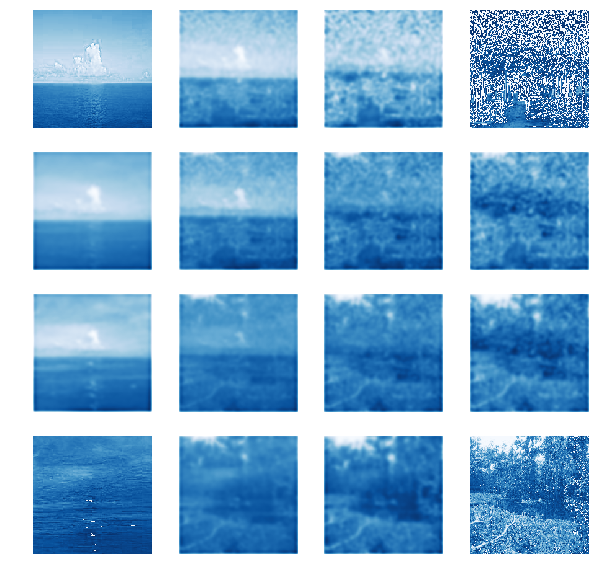

In [9]:
pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.0001
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)
        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        #print(weights)
        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation wasserstein_barycenter
            # pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            mu0,ite = wasserstein_barycenter(A, weights, reg, 1e-15, sharpening=False)
            print(ite)
            pl.imshow(mu0, cmap=cm)
            pl.axis('off')

pl.savefig('lr_ocean.png')

In [90]:
pl.show()
#pl.savefig('lr.png')

### low regularization + entropic sharpening

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in true_divide


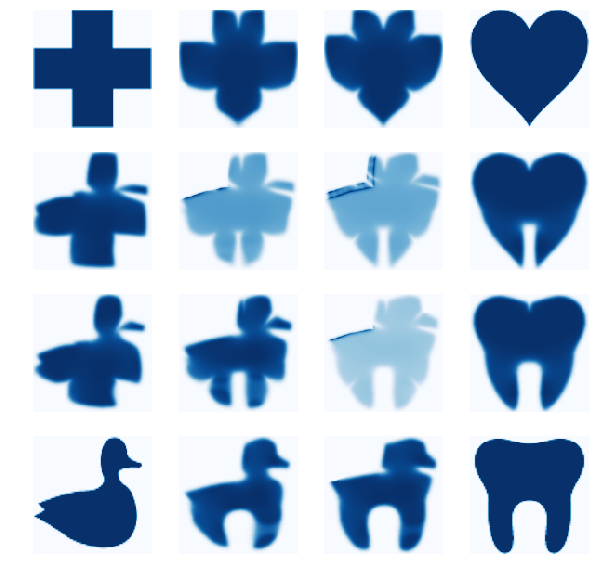

In [12]:
pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.0001
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)
        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        #print(weights)
        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation wasserstein_barycenter
            # pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            pl.imshow(wasserstein_barycenter(A, weights, reg, 1e-15), cmap=cm)
            pl.axis('off')

pl.show()

### high regularization

47
47
50
50
49
41
50
53
52
39
54
54


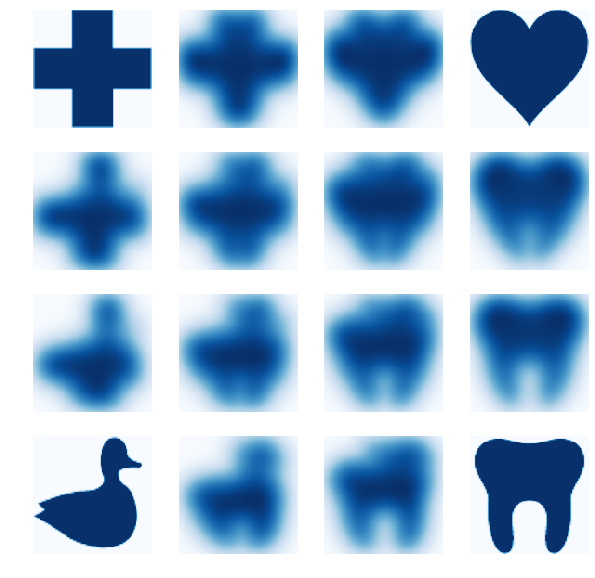

In [83]:
pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.005
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)
        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        #print(weights)
        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation wasserstein_barycenter
            # pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            mu0,ite = wasserstein_barycenter(A, weights, reg, 1e-15, sharpening=False)
            print(ite)
            pl.imshow(mu0, cmap=cm)
            pl.axis('off')

pl.savefig('hhr.png')

### high regularization + entropic sharpenin

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


2963
fine


KeyboardInterrupt: 

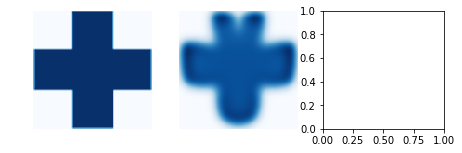

In [88]:
pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.001
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)
        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        #print(weights)
        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation wasserstein_barycenter
            # pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            mu0,ite = wasserstein_barycenter(A, weights, reg, 1e-15)
            print(ite)
            pl.imshow(mu0, cmap=cm)
            pl.axis('off')

pl.savefig('hr.png')

## Euclidean barycenter

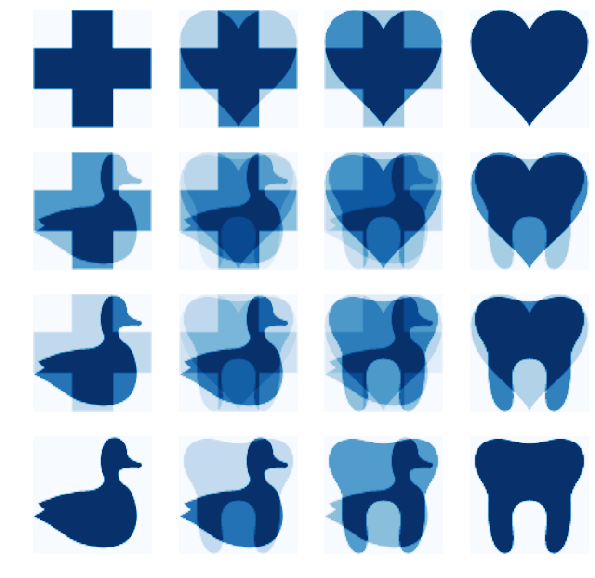

In [67]:
pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.001
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)
        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        #print(weights)
        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation wasserstein_barycenter
            # pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            pl.imshow(np.transpose(A,axes = [1,2,0]).dot(weights), cmap=cm)
            pl.axis('off')

#pl.show()
pl.savefig('euc.png')

In [36]:
w = np.array((1, 0, 0, 0))
w

array([1, 0, 0, 0])

In [44]:
np.dot(A.transpose(),w)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
A.shape

(4, 128, 128)

In [56]:
np.transpose(A,axes = [1,2,0]).shape

(128, 128, 4)

In [58]:
np.transpose(A,axes = [1,2,0]).dot(w).shape

(128, 128)

In [65]:
pwd

'C:\\Users\\Oliver\\Documents\\资料（课件）\\2019 fall\\stat992_OT\\Project\\implement'